In [ ]:
!rm -r AI_USI_MA/
!git clone https://github.com/UmbertoJr/AI_USI_MA.git

rm: cannot remove 'AI_USI_MA/': No such file or directory
Cloning into 'AI_USI_MA'...
remote: Enumerating objects: 430, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 430 (delta 67), reused 126 (delta 35), pack-reused 265
Receiving objects: 100% (430/430), 14.31 MiB | 13.88 MiB/s, done.
Resolving deltas: 100% (197/197), done.


# The Orienteering Problem with Time Windows

column of X:

0. index of the customer
1. x coordinate
2. y coordinate
3. lower time window
4. uppper time window
5. reward customer
6. global time constraint

adj is the distance matrix

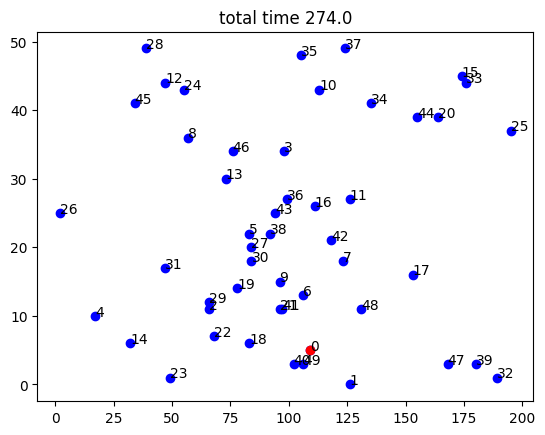

[[0.00e+00 1.09e+02 5.00e+00 0.00e+00 2.74e+02 0.00e+00 2.74e+02]
 [1.00e+00 1.26e+02 0.00e+00 2.13e+02 2.32e+02 1.70e-01 2.74e+02]
 [2.00e+00 6.60e+01 1.10e+01 2.31e+02 2.31e+02 4.00e-01 2.74e+02]
 [3.00e+00 9.80e+01 3.40e+01 1.31e+02 1.69e+02 2.90e-01 2.74e+02]
 [4.00e+00 1.70e+01 1.00e+01 1.82e+02 1.82e+02 8.40e-01 2.74e+02]]
(50, 7)
(50, 50)


In [ ]:
import numpy as np
from AI_USI_MA.OPTW import Env, plot_instance

env = Env(from_file=True, instance_number=0)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

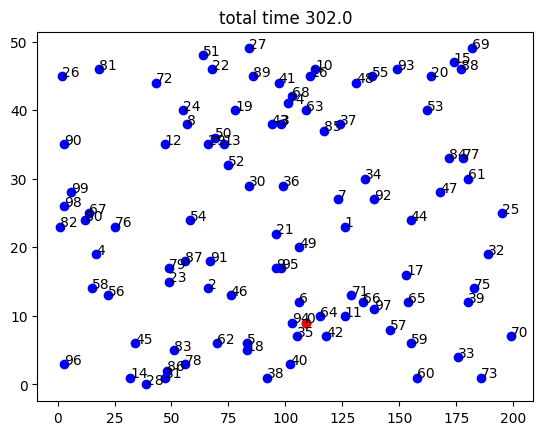

[[0.00e+00 1.09e+02 9.00e+00 0.00e+00 3.02e+02 0.00e+00 3.02e+02]
 [1.00e+00 1.26e+02 2.30e+01 2.06e+02 2.25e+02 2.00e-01 3.02e+02]
 [2.00e+00 6.60e+01 1.40e+01 4.00e+01 7.10e+01 3.80e-01 3.02e+02]
 [3.00e+00 9.80e+01 3.80e+01 1.17e+02 1.49e+02 2.80e-01 3.02e+02]
 [4.00e+00 1.70e+01 1.90e+01 2.09e+02 2.09e+02 8.20e-01 3.02e+02]]
(100, 7)
(100, 100)


In [ ]:
env = Env(from_file=True, instance_number=1)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

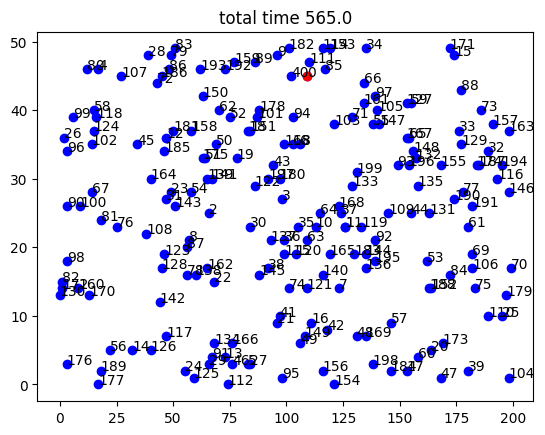

[[0.00e+00 1.09e+02 4.50e+01 0.00e+00 5.65e+02 0.00e+00 5.65e+02]
 [1.00e+00 1.26e+02 2.30e+01 1.41e+02 1.78e+02 2.50e-01 5.65e+02]
 [2.00e+00 6.60e+01 2.50e+01 5.18e+02 5.18e+02 4.10e-01 5.65e+02]
 [3.00e+00 9.80e+01 2.70e+01 2.40e+01 7.10e+01 1.90e-01 5.65e+02]
 [4.00e+00 1.70e+01 4.60e+01 4.73e+02 4.73e+02 8.00e-01 5.65e+02]]
(200, 7)
(200, 200)


In [ ]:
env = Env(from_file=True, instance_number=2)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

### check if solution is feasible and print it

In [ ]:
env.adj[49, 18]

39

In [ ]:
X[18]

array([1.80e+01, 8.30e+01, 3.70e+01, 3.86e+02, 4.12e+02, 2.40e-01,
       5.65e+02])

time window violated 225.0 
current time  233.0 
from node 1  to  49
(233.0, 0, False)


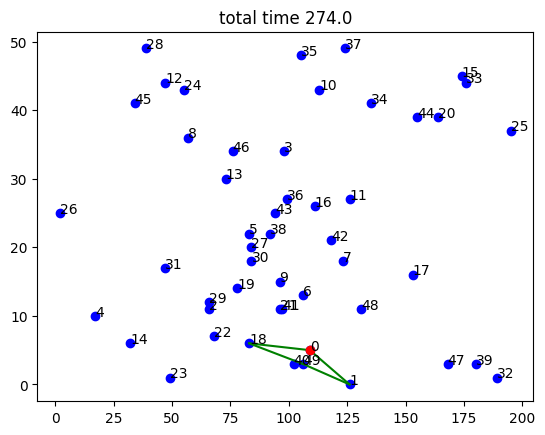

In [ ]:
sol = [0, 1, 49, 18, 0]
env = Env(from_file=True, instance_number=0, verbose=True)
print(env.check_solution(sol))
plot_instance(env.x, sol)

(236.0, 0.44999999999999996, True)


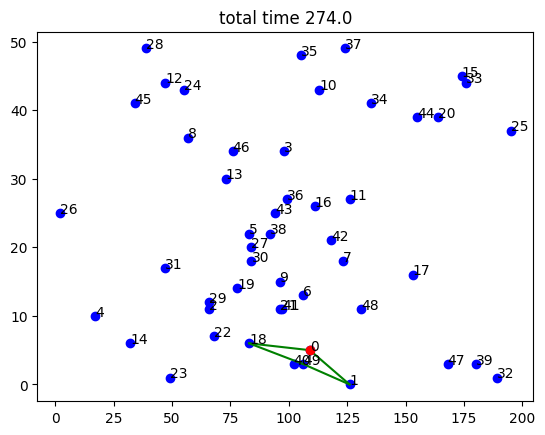

In [ ]:
sol = [0, 18, 49, 1, 0]
env = Env(from_file=True, instance_number=0, verbose=True)
print(env.check_solution(sol))
plot_instance(env.x, sol)

# Monte Carlo Tree Search

### Node class for the Tree Search


In [ ]:
### Node Object ###
class Node:
    def __init__(self, parent, node, travel_time, partial_path, current_reward, expandable_customers):
      self.parent = parent                                                      # parent node object
      self.node = node                                                          # current node (or customer) index
      self.partial_path = partial_path                                          # current partial path across customers
      self.current_reward = current_reward                                      # current reward collected in the partial path
      self.num_of_visit = 0                                                     # number of visit to the current node during the MCTS
      self.terminal = False                                                     # boolean to determine if node is terminal
      self.fully_expanded = False                                               # boolean to determine if node was expanded completely during the search
      self.estimated_reward = 0                                                 # esteem of the future reward collected thanks to the MC simulations
      self.travel_time = travel_time                                            # travel time spent with the current partial path
      self.score = None                                                         # Upper Confidence Buond score for node
      self.policy = None                                                        # IMPORTANT !!!!! Best node index according to the UCB score
      self.expandables = copy.deepcopy(expandable_customers)                    # customers in the candidate list of the current node that are not in the current path
      self.expanded = {}                                                        # nodes already expanded during the search
      if len(self.expandables) == 0:
        self.fully_expanded = True
        self.terminal = True
        self.partial_path.append(0)
        self.policy = 0

    def calculateUCTscore(self, best_reward_so_far):
      # computes the Upper Confidence Bound for the Node
      c=1/(2**0.5)
      self.score = (((self.estimated_reward/ self.num_of_visit) + self.current_reward) /
                    best_reward_so_far) + c * 2 * (2 * np.log(self.parent.num_of_visit) /
                                                   self.num_of_visit) ** 0.5


### MCTS

In [ ]:
from time import time
import copy
import numpy as np
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')


class MCTS:
  def __init__(self, env,time_limit, initial_path):
    self.num_of_customers = env.n_nodes                                         # number of customers in the current problem
    self.env = env                                                              # environment of the problem to solve
    self.time_limit = time_limit                                                # time budget for the OPTW to solve
    self.initial_path = initial_path                                            # initial path
    self.root_node = initial_path[-1]                                           # root node index

    # saving the best tour so far, its reward and time travel
    self.best_tour_so_far = initial_path + [0]
    travel_time, self.max_reward, _ = self.env.check_solution(self.best_tour_so_far)

    # these operations find the promising CL for the root node
    ordered_view = {i: self.env.x[i, 5]/(self.env.x[i, 3] / self.env.x[i, 6]) for i in range(1, self.num_of_customers) if i not in initial_path
                    and self.env.adj[self.root_node, i] + travel_time < self.env.x[i, 4]
                    and self.env.adj[i, 0] + self.env.adj[self.root_node, i] + travel_time < self.env.x[i, 6]}
    ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: item[1]) if k not in initial_path]

    # initialize the root node
    self.root = Node(parent=None,
                     node= self.root_node,
                     travel_time =travel_time,
                     partial_path=initial_path,
                     current_reward=0,
                     expandable_customers = ordered_list)


  def treePolicy(self, node):
    """
    This function expand a node if the selected node is not being completely expanded,
    otherwise it select the best child in the Tree using the selectBestChild function
    """
    while node.terminal == False:                     # check whether the node is a leaf
            if node.fully_expanded == False:          # check whether all the children of the node have been individuated
                return self.expand(node)
            else:
                node = self.selectBestChild(node)

    return node


  def selectBestChild(self, node):
    """
    The function updates the UBC score for each child node by employing the updated max_reward
    then it returns the best child according to such score.
    """
    best_score = 0
    best_child = None

    for child_index, child_node in node.expanded.items():

      child_node.calculateUCTscore(self.max_reward) # calculate UCT score

      if child_node.score > best_score:             # update best child and best score if a higher score is found
        best_score = child_node.score
        best_child = child_node

    return best_child


  def expand(self, node):
    new_node = node.expandables.pop()                                           # it selects the most promising node from the CL
    new_path = copy.deepcopy(node.partial_path)                                 # it copies the path and append new node to it
    new_path.append(new_node)

    new_reward = node.current_reward                                            # update of the reward for the new customer
    new_reward += self.env.x[new_node, 5]

    new_travel_time = max(node.travel_time + self.env.adj[node.node, new_node], # updated the travel time
                          self.env.x[new_node, 3])

    # these operations find the promising CL for the root node
    ordered_view = {i: self.env.x[i, 5]/(self.env.x[i, 3] / self.env.x[i, 6]) for i in range(1, self.num_of_customers) if i not in new_path
                    and self.env.adj[new_node, i] + new_travel_time < self.env.x[i, 4]
                    and self.env.adj[i, 0] + self.env.adj[new_node, i] + new_travel_time < self.env.x[i, 6]}
    ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: item[1]) if k not in new_path]

    new_node_object = Node(parent=node,
                           node=new_node,
                           travel_time=new_travel_time,
                           partial_path=new_path,
                           current_reward=new_reward,
                           expandable_customers=ordered_list)

    node.expanded[new_node] = new_node_object
    if len(node.expandables) == 0:
      node.fully_expanded = True

    if new_node == 0:
      new_node_object.terminal = True
      _, new_r, _ = self.env.check_solution(new_path)
      if new_r > self.max_reward:
        self.max_reward = new_r
        self.best_tour_so_far = new_path

    return new_node_object

  def defaultPolicy(self, starting_node):
    # reach the end, break condition
    if starting_node.node == 0:
      return 0

    customer = starting_node.node
    new_path = starting_node.partial_path
    travel_time = starting_node.travel_time
    while customer != 0:
      # these operations find the promising CL for the root node
      ordered_view = {i: (self.env.x[i, 5] + np.finfo(float).eps)/(self.env.x[i, 3] / self.env.x[i, 6] + np.finfo(float).eps ) for i in range(1, self.num_of_customers) if i not in new_path
                      and self.env.adj[customer, i] + travel_time < self.env.x[i, 4]
                      and self.env.adj[i, 0] + self.env.adj[customer, i] + travel_time < self.env.x[i, 6]}
      ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: -item[1]) if k not in new_path]
      if len(ordered_list) == 0:
        customer = 0
      else:
        probabilities = softmax(np.array([v for k, v in sorted(ordered_view.items(), key=lambda item: -item[1]) if k not in new_path]))
        customer = int(np.random.choice(ordered_list, 1, p=probabilities))

      new_path.append(customer)
      travel_time = max(travel_time + self.env.adj[new_path[-2], customer], self.env.x[customer, 3])

    _, new_r, _ = self.env.check_solution(new_path)
    if new_r > self.max_reward:
        self.max_reward = new_r
        self.best_tour_so_far = new_path

    return new_r - starting_node.current_reward


  def backup(self, node, reward_esteem):
    """
    backup of the estimated reward in the MCTS
    """
    while node is not None:
            node.num_of_visit += 1                    # update the visit count for the current node
            node.estimated_reward += reward_esteem    # update the estimated reward for the current node
            node = node.parent                        # move to the parent node
    pass

  def step(self, num_of_simulation=1):
    start = time()
    while time() - start < self.time_limit:
        current_node = self.treePolicy(self.root)
        reward_esteem = self.defaultPolicy(current_node)
        self.backup(current_node, reward_esteem)

    return self.root.policy if self.root.policy != None else 0

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

seeds = [101,102,103]
instances = [0,1,2]
time_limit = 5
c_labels = ['Instance','Seed','Time best solution', 'Reward', 'Feasible solution']

Seed:  101
Instance 0, Seed 101
(274.0, 1.49, True)


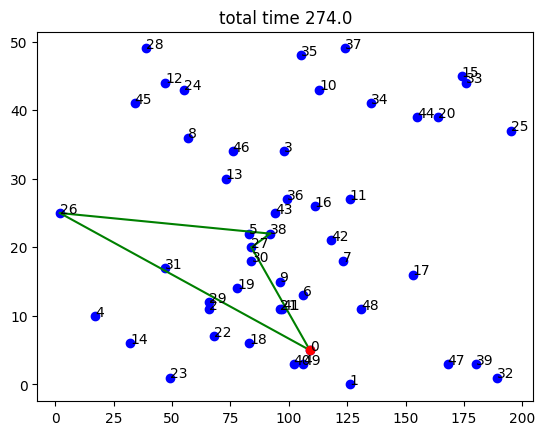

Instance 1, Seed 101
(302.0, 1.55, True)


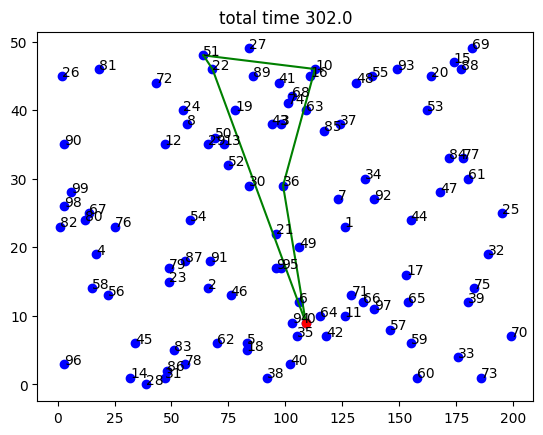

Instance 2, Seed 101
(565.0, 2.34, True)


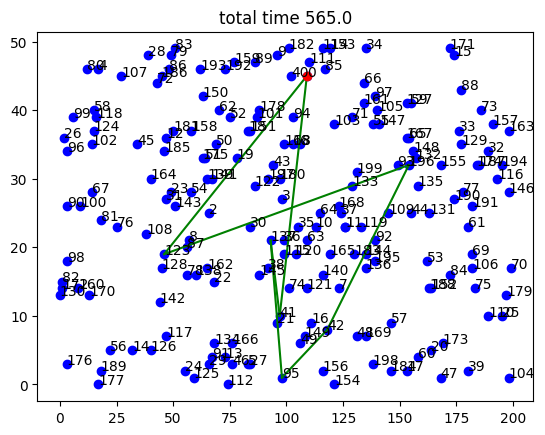

Seed:  102
Instance 0, Seed 102
(274.0, 1.7999999999999998, True)


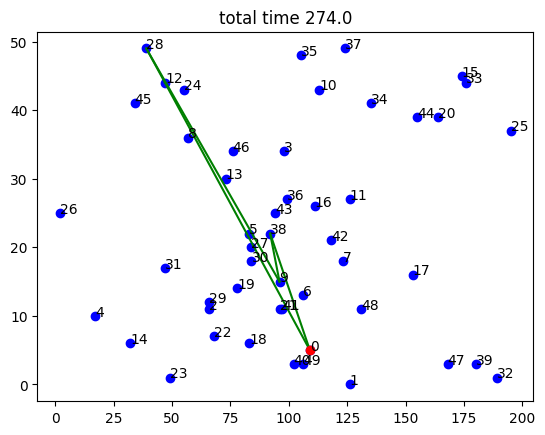

Instance 1, Seed 102
(302.0, 1.6300000000000001, True)


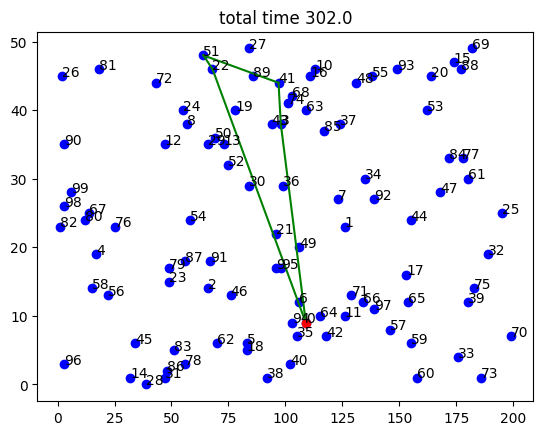

Instance 2, Seed 102
(565.0, 2.6, True)


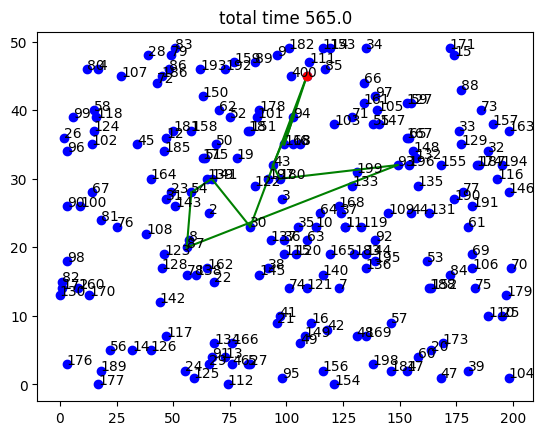

Seed:  103
Instance 0, Seed 103
(274.0, 2.49, True)


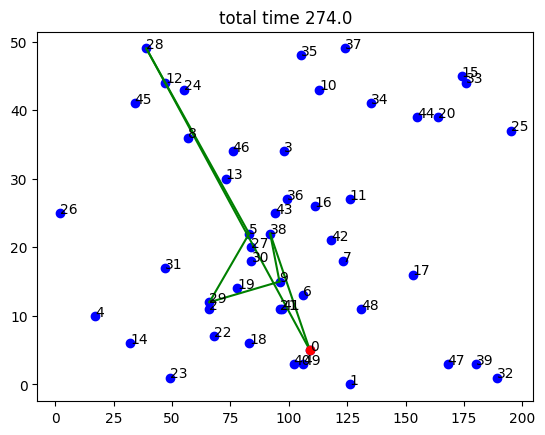

Instance 1, Seed 103
(302.0, 1.75, True)


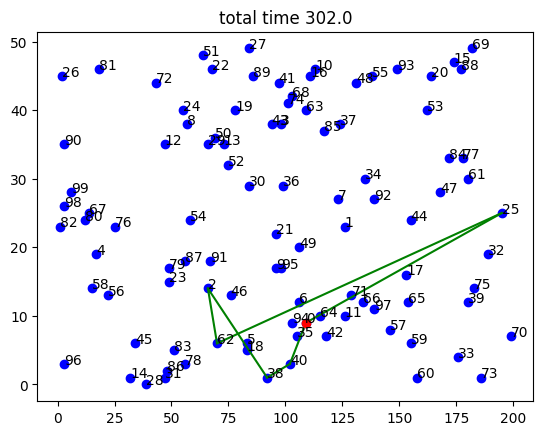

Instance 2, Seed 103
(565.0, 2.35, True)


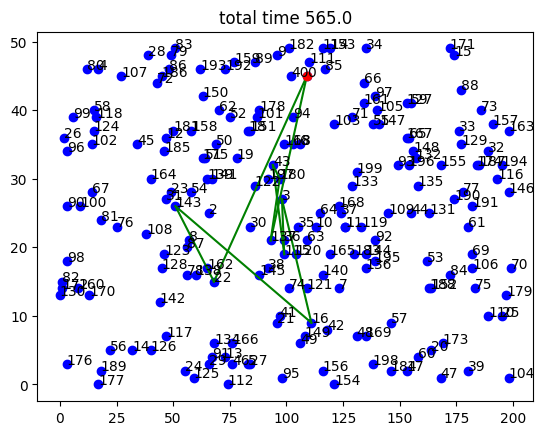

In [ ]:
data = []

for s in range(len(seeds)):
    seed = seeds[s]
    print('Seed: ', seed)

    for ic_n in instances:

      np.random.seed(seed)

      env = Env(from_file=True, instance_number=ic_n)
      sol = [0]
      best_sol = None
      best_r = 0

      while True:
        mcts = MCTS(env, time_limit, sol)
        mcts.best_tour_so_far = best_sol
        mcts.max_reward = best_r
        new_customer = mcts.step()
        sol.append(new_customer)
        if mcts.max_reward > best_r:
          best_r = mcts.max_reward
          best_sol = mcts.best_tour_so_far
        if sol[-1] == 0:
          break

      env_data = env.check_solution(best_sol)
      time_best_sol = env_data[0]
      reward = env_data[1]
      feasible = env_data[2]

      print(f'Instance {ic_n}, Seed {seed}')
      print(env_data)
      plot_instance(env.x, best_sol)

      data.append([ic_n,seed,time_best_sol,reward,feasible])

plt.show()

df = pd.DataFrame(data, columns=c_labels)

In [ ]:
df

,Instance,Seed,Time best solution,Reward,Feasible solution
0,0,101,274.0,1.49,True
1,1,101,302.0,1.55,True
2,2,101,565.0,2.34,True
3,0,102,274.0,1.80,True
4,1,102,302.0,1.63,True
5,2,102,565.0,2.60,True
6,0,103,274.0,2.49,True
7,1,103,302.0,1.75,True
8,2,103,565.0,2.35,True


In [ ]:
duplicate_rows = df[df.duplicated(subset=['Instance', 'Feasible solution'], keep=False)]
aggregation = {'Time best solution': 'mean', 'Reward': 'mean'}
small_df = duplicate_rows.groupby(['Instance','Feasible solution'], as_index=False).agg(aggregation)
small_df = small_df.round({'Time best solution': 3, 'Reward': 3})
small_df

,Instance,Feasible solution,Time best solution,Reward
0,0,True,274.0,1.927
1,1,True,302.0,1.643
2,2,True,565.0,2.430



# Comments

The dataset `small_df` is obtained from `df` by avaraging over the seed. In this section, I will breafly comment the obtained results.


*   I cannot compare the obtained rewards with the exact otpimal ones, since they are not given.
*   The size of the instance does not influence too much the magnitude of the reward: the small-sized instance 0 has an expected reward which is higher than the medium-sized instance 1 and lower thank the large-sized instance 2.
*   All the solutions are feasible, suggesting that the algorithm is valid.
*   By looking at the plots, I see that sometimes the path crosses itself in certain points, suggesting that maybe one could improve the result by permuting the found solution in a way that the path does not cross.